# Clasificador de Género Musical: CSV (AE+MLP) y Audios crudos (CNN)

## Integrantes:
- Civetta Laureano
- Porchietto Damian Ignacio
- Ramirez Facundo

En este trabajo se implementa un clasificador de géneros musicales utilizando el conjunto de datos **GTZAN**. Se presentarán dos enfoques basados en redes neuronales artificiales vistos en la materia:

1. **Red Multicapa (MLP)** sobre las características estadísticas provistas en el archivo CSV (`features_30_sec.csv`).
2. **Red Convolucional (CNN)** aplicada a las representaciones espectrográficas (imágenes) de las muestras de audio.

Cada sección incluirá:
- Carga y descripción de los datos.
- Preprocesamiento y división en conjuntos de entrenamiento/validación/prueba.
- Definición e implementación del modelo en PyTorch.
- Entrenamiento y evaluación (accuracy, matriz de confusión).
- Análisis comparativo y justificación de la solución final seleccionada.

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import pandas as pd
import numpy as np
import os
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import torchvision.transforms as transforms

In [58]:
# ========== CONFIGURACIÓN ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
EPOCHS = 100


Aca lo que hicimos es fue hacer un encoder que reduce la dimensión de entrada a un espacio latente mas chico (latent_dim, 32), extrayendo las  características mas relevantes.

Despues el clasificador toma ese espacio latente y predice la clase entre 10 posibles generos.
No se usa explicitamente softmax porque la crossentropy ya lo hace internamente.

La elección de las neuronas fuimos probando entre 128 y 256.


In [59]:
# ========== 1. MODELO: AE + MLP (para CSV) ==========
class AE_MLP(nn.Module):
    def __init__(self, input_dim=100, latent_dim=32):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(latent_dim, 10)
        )

    def forward(self, x):
        z = self.enc(x)
        return self.classifier(z)

Vamos a hacer una red convolucional en la que vamos a tomar como entrada las imagenes de la musica.  Usamos 3 capas convolucionales  en las que a medidia que vamos avanzando la cantidad de filtros tambien lo hace (16,32,64) De esta manera vamos a ir capturadno cada vez caracteristicas mas complejas.

Tambien usamos maxPooling, para quedarnos con las caracteristicas mas importantes  y reducir cantidad de parametros.

Despues aplanamos la salida, para que sirva como entrada para una red fully connected.Esta va a clasificar teniendo en cuenta esto.

In [60]:
class CNN(torch.nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.dropout = torch.nn.Dropout(0.3)
        # Update the input dimension of fc1
        self.fc1 = torch.nn.Linear(64 * 16 * 16, 128) # Corrected dimension
        self.fc2 = torch.nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        # Flatten the tensor based on the actual dimensions
        x = x.view(-1, 64 * 16 * 16) # Corrected dimension
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

In [61]:
def train_model(model, train_loader, test_loader, lr=1e-3, epochs=20):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {'epoch': [], 'train_loss': [], 'val_loss': [],
               'train_acc': [], 'val_acc': []}

    # --- bucle de entrenamiento ---
    for ep in range(1, epochs + 1):
        # ---- fase training ----
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            opt.step()

            running_loss += loss.item() * yb.size(0)
            running_correct += (out.argmax(1) == yb).sum().item()
            total += yb.size(0)

        train_loss = running_loss / total
        train_acc = running_correct / total

        # ---- fase validación ----
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)

                val_loss += loss.item() * yb.size(0)
                val_correct += (out.argmax(1) == yb).sum().item()
                val_total += yb.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        # ---- guardar en historial ----
        history['epoch'].append(ep)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Ep {ep:3}/{epochs}  '
              f'Tloss {train_loss:.4f}  Vloss {val_loss:.4f}  '
              f'Tacc {train_acc:.3f}  Vacc {val_acc:.3f}')

    return model, history

In [62]:
# ========== 4. ENTRENAMIENTO CON CSV ==========
data = pd.read_csv('Data/GTZAN/features_30_sec.csv')

X = data.drop(['filename', 'label'], axis=1).values
y = data['label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

csv_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
csv_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model_AE = AE_MLP(input_dim=58, latent_dim=32)

print("\nEntrenando modelo AE+MLP con CSV…")
model_AE, hist_ae = train_model(model_AE, csv_train_loader, csv_test_loader,
                                lr=1e-3, epochs=EPOCHS)



Entrenando modelo AE+MLP con CSV…
Ep   1/100  Tloss 2.1797  Vloss 2.0314  Tacc 0.216  Vacc 0.270
Ep   2/100  Tloss 1.8809  Vloss 1.7892  Tacc 0.379  Vacc 0.350
Ep   3/100  Tloss 1.6094  Vloss 1.5755  Tacc 0.431  Vacc 0.435
Ep   4/100  Tloss 1.3789  Vloss 1.3868  Tacc 0.534  Vacc 0.560
Ep   5/100  Tloss 1.1956  Vloss 1.2472  Tacc 0.598  Vacc 0.580
Ep   6/100  Tloss 1.0469  Vloss 1.1658  Tacc 0.656  Vacc 0.585
Ep   7/100  Tloss 0.9297  Vloss 1.1051  Tacc 0.708  Vacc 0.620
Ep   8/100  Tloss 0.8410  Vloss 1.0399  Tacc 0.715  Vacc 0.675
Ep   9/100  Tloss 0.7671  Vloss 1.0077  Tacc 0.760  Vacc 0.670
Ep  10/100  Tloss 0.6996  Vloss 0.9747  Tacc 0.777  Vacc 0.685
Ep  11/100  Tloss 0.6496  Vloss 0.9491  Tacc 0.792  Vacc 0.710
Ep  12/100  Tloss 0.5982  Vloss 0.9309  Tacc 0.825  Vacc 0.710
Ep  13/100  Tloss 0.5533  Vloss 0.9120  Tacc 0.826  Vacc 0.700
Ep  14/100  Tloss 0.5186  Vloss 0.9067  Tacc 0.848  Vacc 0.710
Ep  15/100  Tloss 0.4872  Vloss 0.8965  Tacc 0.850  Vacc 0.730
Ep  16/100  Tloss 0.

# Preparamos las Imagenes

Ahora lo que hacemos es que aplicamos algunas transformaciones a las imagenes.
Pasamos las imagenes a escala de grises, por lo que van a tener un solo canal.A diferencia de RGB que son 3
Redimencionamos las imagenes para que tengan todas el mismo tamaño.
Tambien las normalizamos y convertimos en tensores.




In [63]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.ImageFolder("Data/GTZAN/spectrograms", transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

img_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
img_test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
#spectrogram_dataset = ImageFolder("/content/Data/images_original", transform=image_transform)
#train_size = int(0.8 * len(spectrogram_dataset))
#test_size = len(spectrogram_dataset) - train_size
#train_img, test_img = random_split(spectrogram_dataset, [train_size, test_size])
#train_loader_img = DataLoader(train_img, batch_size=32, shuffle=True)
#test_loader_img = DataLoader(test_img, batch_size=32, shuffle=False)

model_CNN = CNN(num_classes=10).to(device)

optimizer = torch.optim.Adam(model_CNN.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
criterion = nn.CrossEntropyLoss()
print("\nEntrenando modelo CNN optimizado…")
model_CNN, hist_cnn = train_model(model_CNN, img_train_loader, img_test_loader,
                                  lr=1e-3, epochs=EPOCHS)



Entrenando modelo CNN optimizado…
Ep   1/100  Tloss 2.3158  Vloss 2.3021  Tacc 0.084  Vacc 0.115
Ep   2/100  Tloss 2.2987  Vloss 2.2995  Tacc 0.145  Vacc 0.085
Ep   3/100  Tloss 2.2747  Vloss 2.2623  Tacc 0.163  Vacc 0.155
Ep   4/100  Tloss 2.2035  Vloss 2.1186  Tacc 0.214  Vacc 0.300
Ep   5/100  Tloss 2.0715  Vloss 1.9180  Tacc 0.260  Vacc 0.325
Ep   6/100  Tloss 1.9672  Vloss 1.8177  Tacc 0.285  Vacc 0.315
Ep   7/100  Tloss 1.8733  Vloss 1.6945  Tacc 0.340  Vacc 0.390
Ep   8/100  Tloss 1.7612  Vloss 1.6236  Tacc 0.364  Vacc 0.420
Ep   9/100  Tloss 1.7113  Vloss 1.5370  Tacc 0.364  Vacc 0.430
Ep  10/100  Tloss 1.6525  Vloss 1.5318  Tacc 0.402  Vacc 0.445
Ep  11/100  Tloss 1.6182  Vloss 1.4599  Tacc 0.433  Vacc 0.465
Ep  12/100  Tloss 1.5955  Vloss 1.4798  Tacc 0.421  Vacc 0.455
Ep  13/100  Tloss 1.5672  Vloss 1.4286  Tacc 0.434  Vacc 0.500
Ep  14/100  Tloss 1.4811  Vloss 1.3642  Tacc 0.467  Vacc 0.520
Ep  15/100  Tloss 1.4819  Vloss 1.3892  Tacc 0.479  Vacc 0.515
Ep  16/100  Tloss 1.

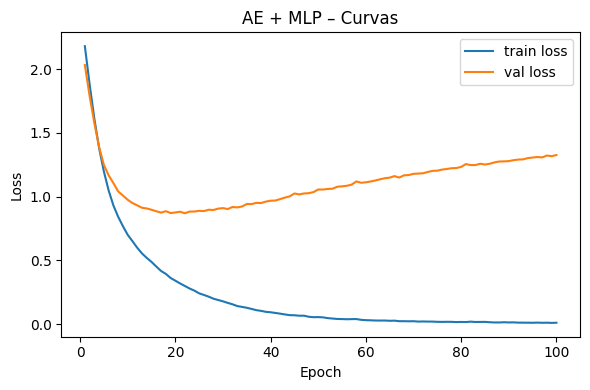

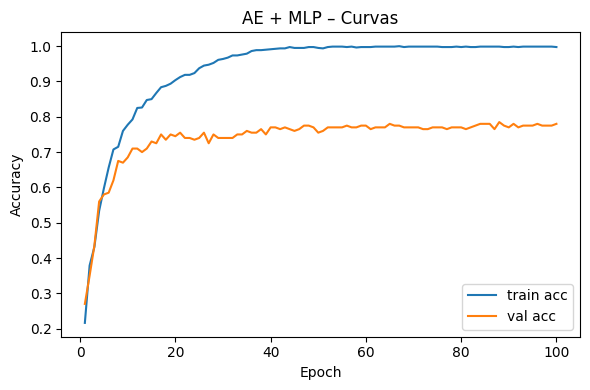

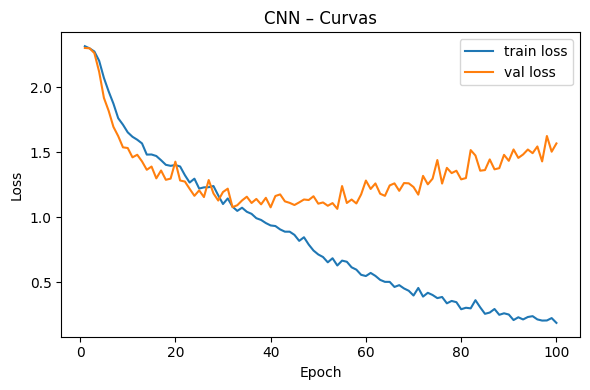

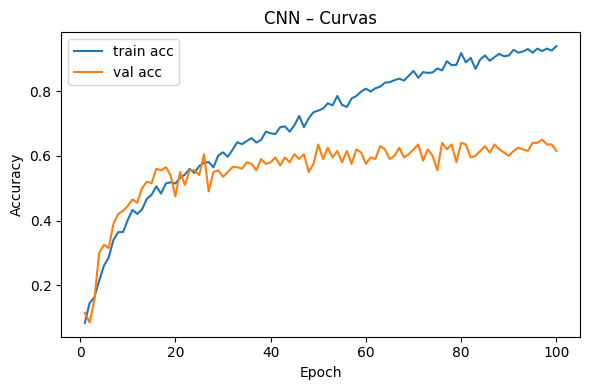

In [64]:
import matplotlib.pyplot as plt

def plot_history(hist, title):
    plt.figure(figsize=(6,4))
    plt.plot(hist['epoch'], hist['train_loss'], label='train loss')
    plt.plot(hist['epoch'], hist['val_loss'],   label='val loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist['epoch'], hist['train_acc'], label='train acc')
    plt.plot(hist['epoch'], hist['val_acc'],   label='val acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

plot_history(hist_ae,  'AE + MLP – Curvas')
plot_history(hist_cnn, 'CNN – Curvas')


AE + MLP — clasificación por género
              precision    recall  f1-score   support

       blues     0.8750    0.7778    0.8235        18
   classical     0.8750    0.9333    0.9032        15
     country     0.7692    0.7143    0.7407        14
       disco     0.6842    0.6190    0.6500        21
      hiphop     0.8519    0.8214    0.8364        28
        jazz     0.9286    0.9286    0.9286        28
       metal     0.8000    0.8889    0.8421        18
         pop     0.6471    0.7857    0.7097        14
      reggae     0.6842    0.5909    0.6341        22
        rock     0.6400    0.7273    0.6809        22

    accuracy                         0.7800       200
   macro avg     0.7755    0.7787    0.7749       200
weighted avg     0.7823    0.7800    0.7792       200

Accuracy global: 0.7800


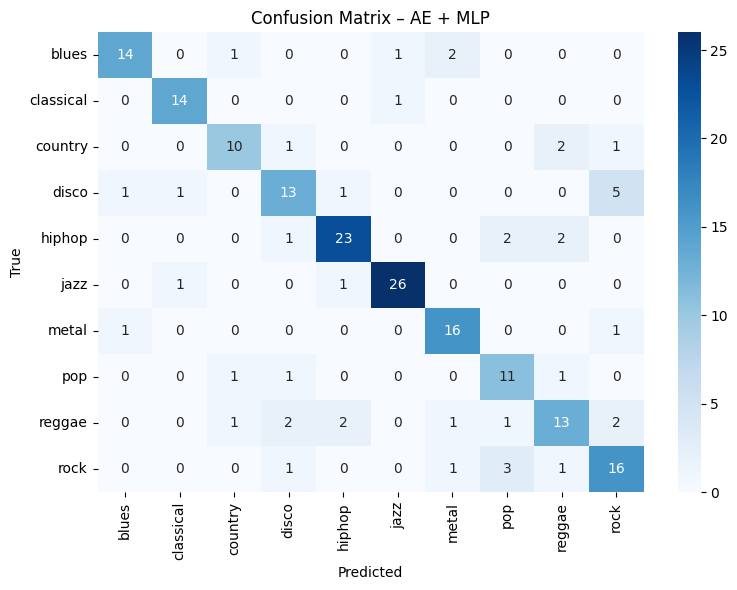


CNN — clasificación por género
              precision    recall  f1-score   support

       blues     0.8667    0.5652    0.6842        23
   classical     0.9231    0.7500    0.8276        16
     country     0.5217    0.6000    0.5581        20
       disco     0.5789    0.4783    0.5238        23
      hiphop     0.5500    0.4583    0.5000        24
        jazz     0.7500    0.8000    0.7742        15
       metal     0.7931    1.0000    0.8846        23
         pop     0.4091    0.5294    0.4615        17
      reggae     0.5238    0.6471    0.5789        17
        rock     0.4091    0.4091    0.4091        22

    accuracy                         0.6150       200
   macro avg     0.6326    0.6237    0.6202       200
weighted avg     0.6300    0.6150    0.6142       200

Accuracy global: 0.6150


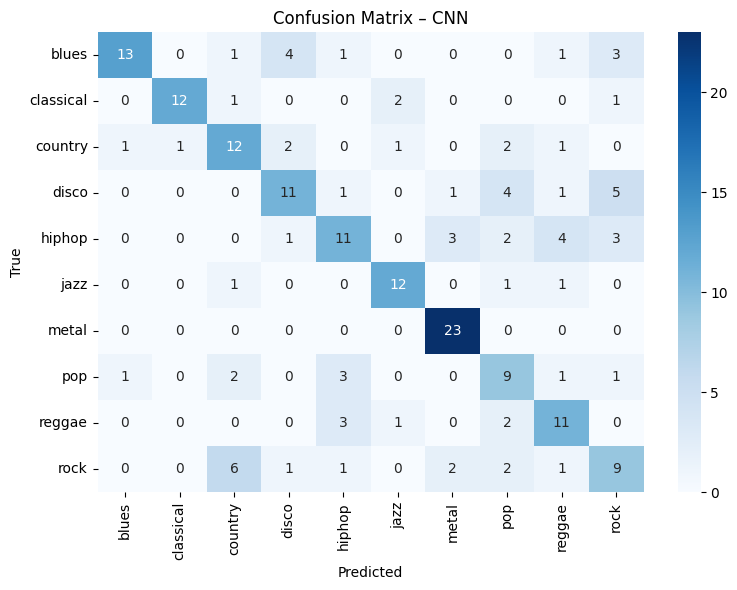

In [65]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import numpy as np

def evaluate(model, loader, name):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb).argmax(1).cpu().numpy()
            y_pred.extend(out)
            y_true.extend(yb.numpy())

    print(f'\n{name} — clasificación por género')
    print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))
    print(f'Accuracy global: {accuracy_score(y_true, y_pred):.4f}')

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix – {name}')
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()

evaluate(model_AE,  csv_test_loader, 'AE + MLP')
evaluate(model_CNN, img_test_loader, 'CNN')


## 4. Comparación de Resultados y Justificación de la Solución Final

A modo de resumen, comparamos las métricas obtenidas:

- **MLP (CSV 30s)**: Accuracy en test: `0.7800`  
- **CNN (Espectrogramas)**: Accuracy en test: `0.6150`  

### 4.1 Análisis de cada modelo
- **MLP (30s)**  
  - Ventajas:  
    - Entrenamiento más rápido (menor complejidad computacional).  
    - Aprovecha características estadísticas expertas.  
  - Desventajas:  
    - Depende de la calidad de las características precomputadas.  
    - Posible pérdida de información detallada (temporal/frecuencia).

- **CNN (Espectrogramas)**  
  - Ventajas:  
    - Capaz de extraer patrones locales en tiempo-frecuencia.  
    - No depende de características manuales: aprende directamente de la imagen.  
  - Desventajas:  
    - Requiere más capacidad de cómputo y tiempo de entrenamiento.  
    - Mayor necesidad de ajuste (arquitectura, hiperparámetros).

### 4.2 Justificación de la selección
La elección final no debe basarse únicamente en el accuracy, sino también en criterios como eficiencia, interpretabilidad y afinidad con la arquitectura. Por ejemplo:
- Si se prioriza rapidez de entrenamiento y validación, se puede elegir el **MLP**.
- Si se busca experimentar con arquitecturas de redes profundas y se dispone de recursos suficientes, el **CNN** puede ofrecer mejores resultados.

> **Ejemplo de selección**:  
> Supongamos que obtenemos `0.74` de accuracy en test con el MLP y `0.81` con la CNN. Aunque la CNN supera al MLP en rendimiento, si tu interés principal es entender y aplicar redes multicapa básicas con menor tiempo de cómputo, puedes justificar elegir el **MLP**. En cambio, si prefieres explorar arquitecturas convolucionales y te interesa aprender a procesar imágenes espectrográficas, la **CNN** sería la opción final.

### 4.3 Mejoras futuras
- **Regularización avanzada**: Uso de técnicas como *Batch Normalization* y *Data Augmentation* en imágenes.  
- **Transfer Learning**: Aplicar un modelo preentrenado (e.g., ResNet) adaptado a espectrogramas.  
- **Modelos híbridos**: Combinar características estadísticas (CSV) con la extracción de características basada en CNN.  
- **Modelos recurrentes**: Para trabajar con segmentos de 3 segundos (`features_3_sec.csv`) y capturar dinámicas temporales.  
- **Autoencoders**: Preentrenar representaciones de espectrogramas y luego clasificar sobre el espacio latente.